# Panda Example

In [1]:
import scipy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time, os
from IPython.display import clear_output
from IPython.core import display

import pybullet as p
import pybullet_data
import networkx as nx

import pinocchio as pin
from utils import *
from costs import *
from robot import *
from functools import partial

import tensorflow as tf
import tensorflow.compat.v1 as tf1
from collections import OrderedDict
import tf_robot_learning as rl
import tf_robot_learning.distributions as ds
from tf_robot_learning import kinematic as tk

%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4, suppress=True)

## Part 1: Define and Train GAN

In [2]:
sess = tf1.InteractiveSession()
tf1.disable_eager_execution()

### Define the robot

In [3]:
#define the robot as a kinematic chain, loaded from urdf
urdf = tk.urdf_from_file(rl.datapath +
                         '/urdf/panda_arm.urdf');
chain = tk.kdl_chain_from_urdf_model(
    urdf, tip='panda_hand'
)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Material has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: material

### Load data

In [4]:
data = np.load('data/panda_constrained_orientation.npy')

In [5]:
def q_augmented(q):
#     return q
    return tf.concat([q, fs[0](q)], axis=1)

In [6]:
# get mini batch
def get_batch(_batch_size=30, cut=None, augmented=True):
    if cut is not None: idx = np.random.randint(0, cut, _batch_size)
    else: idx = np.random.randint(0, data_augmented.shape[0]-1, _batch_size)
    if augmented: return data_augmented[idx]
    else: return data[idx]
    
def get_target_batch(_batch_size=30, cut=None):
    if cut is not None: idx = np.random.randint( 0, cut, _batch_size)
    else: idx = np.random.randint(0, data_augmented.shape[0]-1, _batch_size)
    return data_target[idx]

In [7]:
# define transformations of interest (task-spaces)
fs = [
    lambda q : chain.xs(q)[:, -1], # get position and orientation of end-effector
    lambda q : chain.xs(q)[:, -1, :3], # get position end-effector
]

In [8]:
# some utilities to evaluate these functions in tensorflow
q_eval = tf1.placeholder(tf.float32, (None,7))
x_eval = chain.xs(q_eval)
           
q_augmented_eval = q_augmented(q_eval)
q_target_eval = fs[1](q_eval)

In [9]:
# compute data through these transformations
data_augmented = q_augmented_eval.eval({q_eval: data})
data_target = q_target_eval.eval({q_eval: data})

### Model parameters 

In [10]:
# Network Parameters
joint_dim = 7 # panda joint angles
latent_dim = 10 # dimension of noise

target_dim = 3  # size of the target

augmented_dim = data_augmented.shape[-1]  # size of augmented data

batch_size = tf1.placeholder(tf.int32, ())

N_net = 10 # number of NNs

## Generator  

In [11]:
gen_nn = rl.nn.MLP(
    n_input=latent_dim + target_dim, n_output=joint_dim, n_hidden=[200, 200],
    act_fct=tf.nn.relu, batch_size_svi=N_net
)

#### Define the input to generator

In [12]:
# noise to feed generator
eps = tf.random.normal([tf.cast(batch_size/N_net, tf.int32), latent_dim], 
    dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')

# target parameters to feed generator
batch_target = tf1.placeholder(tf.float32, (None, target_dim))

# to feed main generator noise + parameters samples
eps_conc = tf.concat([eps, batch_target], axis=-1)

#### Generator output

In [13]:
# main generator
samples_q = tf.reshape(gen_nn.pred(eps_conc) + tf.constant(chain.mean_pose)[None], (-1,joint_dim))
# compute links of main generator
samples_x = chain.xs(samples_q)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


#### Input with varying noise

In [14]:
# second generator for using the model later with given targets and changing noise
std_guided = tf1.placeholder(tf.float32, ())
eps_guided = tf.random.normal([batch_size, latent_dim], 
    dtype=tf.float32, mean=0., stddev=std_guided, name='epsilon')

guided_samples_q = tf.reshape(gen_nn.pred(
    tf.concat([eps_guided, batch_target], axis=-1)) + tf.constant(chain.mean_pose)[None], (-1,joint_dim))
guided_samples_x = chain.xs(guided_samples_q)

## Discriminator

In [15]:
discr_nn = rl.nn.MLP(
    n_input=augmented_dim, n_output=1, n_hidden=[20, 20],
    act_fct=tf.nn.relu
)

## Define the loss functions

In [16]:
# data in
batch_x = tf1.placeholder(tf.float32, (None, augmented_dim))

In [17]:
# probability to belong to data for data and samples
d_fake = discr_nn.pred(q_augmented(samples_q))[:, 0]
d_true = discr_nn.pred(batch_x)[:, 0]

#### Main loss function (discriminator + generator)

In [18]:
loss_d = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_true), logits=d_true) + \
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_fake), logits=d_fake)
loss_d = tf.reduce_sum(loss_d)

#### Generative loss

In [19]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones_like(d_fake), logits=d_fake)
loss = tf.reduce_sum(loss)

#### Target loss 

In [20]:
p_target_std = tf1.placeholder(tf.float32, ()) 

p_target = ds.MultivariateNormalFullCovariance(
    tf.reshape(tf.ones((N_net, 1,1))*batch_target[None],(-1, target_dim)), p_target_std**2 * tf.eye(3))
    
samples_target_proj = fs[1](samples_q)

loss_target = tf.reduce_sum(-p_target.log_prob(samples_target_proj))
lmbda_target = tf1.placeholder(tf.float32, ())

Instructions for updating:
Do not call `graph_parents`.


#### Constraints Costs

In [21]:
lmbda_constraints = tf1.placeholder(tf.float32, ())
joint_limits = tf.constant(chain.joint_limits, dtype=tf.float32)
joint_limits_std = 0.05
joint_limits_temp = 1.

joint_limits_exp = ds.SoftUniformNormalCdf(
    low=joint_limits[:, 0],
    high=joint_limits[:, 1],
    std=joint_limits_std,
    temp=joint_limits_temp,
    reduce_axis=-1
)
joint_limit_constraints = tf.reduce_mean(-joint_limits_exp.log_prob(samples_q))

#### Overall loss 

In [22]:
loss_gen = loss + lmbda_target * loss_target + lmbda_constraints*joint_limit_constraints

#### Optimizers 

In [23]:
rate = tf1.placeholder(tf.float32, ())
opt = tf1.train.AdamOptimizer

optimizer = opt(learning_rate=rate)
optimizer_d = opt(learning_rate=rate)

gen_var = gen_nn.vec_weights
train = optimizer.minimize(loss_gen, var_list=gen_var)
train_d = optimizer_d.minimize(loss_d, var_list=discr_nn.vec_weights)

# Initialize the variables (i.e. assign their default value)
init = tf1.global_variables_initializer()

#### Train GAN

In [24]:
sess.run(init)

#### To save model

#### To load model

In [25]:
saver = tf1.train.Saver()
saver.restore(sess, "data/panda_gan_target_constrained.ckpt")

INFO:tensorflow:Restoring parameters from data/panda_gan_target_constrained.ckpt


#### Plot distribution

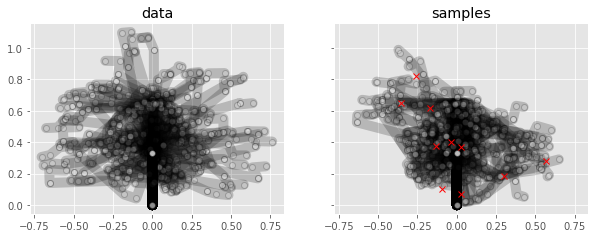

In [26]:
n = 100
# _targets = np.random.multivariate_normal(
                        # [0.4, 0., 0.2], 0.3 ** 2 * np.eye(3), (n,))
_targets = get_target_batch(_batch_size=int(n/N_net))

_samples_q,_samples_xs = sess.run([
        samples_q, samples_x], {batch_size: n, batch_target: _targets})
    
_data_q = get_batch(n, augmented=False) 
_data_q += np.random.normal(0., 0.05, (n, 7))
_data_xs =  sess.run(x_eval, feed_dict={q_eval: _data_q})


fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))

dims = [0, 2]
ax[0].set_title('data')
chain.plot(_data_xs, dim=dims, alpha=0.2, color='k', ax=ax[0])
ax[1].set_title('samples')
chain.plot(_samples_xs, dim=dims, alpha=0.2, color='k', ax=ax[1])

ax[1].plot(_targets[:, dims[0]], _targets[:, dims[1]], 'rx')


#### Plot target distribution 

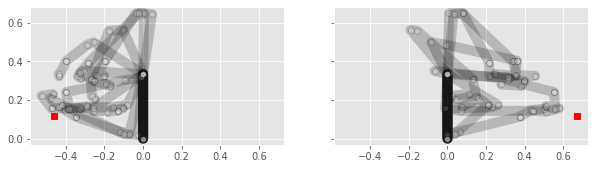

In [27]:
n = 1

_target = get_target_batch(cut=5000, _batch_size=1)[0]
# _target = np.random.multivariate_normal([0.4, 0., 0.2], 0.2 ** 2 * np.eye(3))
_targets = _target[None] * np.ones((n, 1)) 

_samples_x = guided_samples_x.eval({batch_size: n, std_guided: 1., batch_target: _targets})

_data_q = get_batch(n, augmented=False)
_data_xs =  sess.run(x_eval, feed_dict={q_eval: _data_q})


fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 3))

for i in range(2):
    dims = [i, 2]
    chain.plot(_samples_x, dim=dims, alpha=0.2, color='k', ax=ax[i])
    ax[i].plot(_targets[0][dims[0]], _targets[0][dims[1]], 'rs')

## Part 2: Use it for Projection, IK and Inverse Kinematics

### Setup Pybullet

In [28]:
physics_client_id = p.connect(p.GUI)
p.setPhysicsEngineParameter(enableFileCaching=0)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)

In [64]:
p.resetSimulation()

### Setup Robot & environment

In [65]:
robot_urdf = rl.datapath + '/urdf/panda_arm.urdf'
robot_id = p.loadURDF(fileName=robot_urdf)
dof = p.getNumJoints(robot_id)
pb_joint_indices = np.arange(7)
joint_limits = get_joint_limits(robot_id,pb_joint_indices)
mean_pose = 0.5*(joint_limits[0]+joint_limits[1])

plane_id = p.loadURDF('plane.urdf')
p.resetBasePositionAndOrientation(plane_id, (0,0,-.5), (0,0,0,1))

table_square_id = p.loadURDF('table_square/table_square.urdf')
p.resetBasePositionAndOrientation(table_square_id, (0.,0,-0.64), (0, 0, 0.7071068, 0.7071068))

table_id = p.loadURDF('table/table.urdf')
p.resetBasePositionAndOrientation(table_id, (.7,0,-0.5), (0, 0, 0.7071068, 0.7071068))

shelf_urdf = rl.datapath + '/urdf/bookshelf_simple_collision.urdf'
shelf_id = p.loadURDF(fileName=shelf_urdf)
p.resetBasePositionAndOrientation(shelf_id, (-0.6,0.6,-0.5), (0, 0, 0, 1.))

#for visualizing the desired target
_,_,ball_id = create_primitives(radius=0.05)

### Load model in pinocchio

In [89]:
robot_urdf = rl.datapath + '/urdf/panda_arm.urdf';
rmodel = pin.buildModelFromUrdf(robot_urdf)
rdata = rmodel.createData()

pin_frame_names = [f.name for f in rmodel.frames]
ee_frame_id = rmodel.getFrameId('panda_hand2')
ee_frame_id2 = rmodel.getFrameId('panda_hand2')


#### Define standard functions

In [90]:
computeJacobian_std = partial(computeJacobian, rmodel, rdata, ee_frame_id)
computePose_std = partial(computePose, rmodel, rdata, ee_frame_id)
set_q_std = partial(set_q,robot_id, pb_joint_indices)

In [91]:
computePose_std2 = partial(computePose, rmodel, rdata, ee_frame_id2)

***

In [92]:
computePose_std(np.zeros(7))

(array([ 0.5997, -0.    ,  0.2873]),
 array([[-0.9975,  0.05  , -0.05  ],
        [ 0.    , -0.7071, -0.7071],
        [-0.0707, -0.7053,  0.7053]]))

In [133]:
computePose_std2(q.flatten())

(array([-0.3711,  0.2839,  0.7839]),
 array([[ 0.9389,  0.3007, -0.1674],
        [-0.2771,  0.949 ,  0.1504],
        [ 0.2041, -0.0948,  0.9743]]))

## Using Cost Model for projection

In [94]:
class CostProjector():
    def __init__(self, cost):
        self.cost = cost
    
    def __call__(self, xk):
        if False not in self.cost.feasibles:    
            #print('Stop at iteration!' + str(self.cost.nfev))
            raise Exception
        
    def project(self, q, ftol = 1e-12, gtol = 1e-12, disp = 0, maxiter = 1000 ):
        #update the variables
        self.cost.reset_iter()
        
        if 'posture' in self.cost.costnames:
            #regularizing around the initial q
            self.cost.costs['posture'].cost.desired_posture = q.copy()
        
        if 'ori_cost' in self.cost.costnames:
            #maintain the current EE pose while correcting its orientation
            pos, ori = computePose_std(q)
            self.cost.costs['ori_cost'].cost.desired_pose[:3] = pos

        status = False
        try:
            res = minimize(self.cost.calc,q,method='l-bfgs-b', jac=self.cost.calcDiff, callback=self.__call__, options={'ftol':ftol, 'gtol':gtol, 'disp':disp, 'maxiter':maxiter})      
        except:
            #Optimization manage to get solution
            status = True
        res = {'stat':status, 'q':  self.cost.qs[-1], 'qs': self.cost.qs, 'nfev': self.cost.nfev, 'feval': self.cost.feval}
        return res

In [95]:
data_target = []
for i in range(data.shape[0]):
    pos, ori = computePose_std(data[i])
    data_target += [pos]
data_target = np.array(data_target)

In [96]:
x = np.array([0.,0.,0.])
#rpy = np.array([0.,np.pi/2,0.])
rpy = np.array([0.,0.,0.])
sel_vec_x = np.array([1,1,1])
sel_vec_rpy = np.array([0,1,1])

pose = np.concatenate((x,rpy))
sv = np.concatenate((sel_vec_x,sel_vec_rpy))

#define orientation cost
ori_cost = CostFrameRPY(rmodel, rdata, pose, ee_frame_id, sv)
#define joint limit cost
bound_cost = CostBound(joint_limits)
posture_cost = CostPosture(rmodel, rdata, np.random.rand(rmodel.nq))

#define Projector
cost_sum = CostSum()
cost_sum.addCost(ori_cost, 10., 'ori_cost', 1e-3)
cost_sum.addCost(bound_cost, 10., 'joint_limit', 1e-5)
cost_sum.addCost(posture_cost, 1e-3, 'posture', 1e3)
projector_constraint = CostProjector(cost_sum)

#Define IK solver
pose_cost = CostFrameRPY(rmodel, rdata, pose, ee_frame_id, np.array([1,1,1,0,1,0]))
cost_sum_ik = CostSum()
cost_sum_ik.addCost(pose_cost, 50., 'pose_cost', 5e-3)
cost_sum_ik.addCost(bound_cost, 100., 'joint_limit', 1e-5)
#cost_sum_ik.addCost(posture_cost, 5e-2, 'posture', 1e3)
projector_pose = CostProjector(cost_sum_ik)

### Use GAN sampler

In [97]:
class gan_sampler():
    def __init__(self, target_sampler):
        self.target_sampler = target_sampler
       
    def sample(self, N=1, _targets = None, var = 1. ):
        if _targets is None:
            _targets = self.target_sampler.sample(N)
            
        _samples_q = sess.run([guided_samples_q], {batch_size: len(_targets), std_guided: var, batch_target: _targets})
        qnew = []
        for i in range(N):
            idx = np.random.randint(N_net)
            q = _samples_q[0][idx*N+i]
            qnew += [q]
        
        return np.array(qnew)

In [98]:
workspace_area = np.array([[-0.6, -0.6 , -0.1], [0.6, 0.6, 1.0]])
#workspace_area = np.array([[-0.8, -0.8 , 0.1], [0.8, 0.8, 1.0]])
target_sampler = sampler(workspace_area)
rob_gan_sampler = gan_sampler(target_sampler)
rob_simple_sampler = sampler(joint_limits)
rob_col_checker = col_checker(robot_id, pb_joint_indices, [ plane_id, shelf_id, table_id, table_square_id])
rob_interpolator = interpolator()

#### Try the projection operator

In [142]:
is_collide = True
while is_collide is True:
    q = rob_simple_sampler.sample().flatten()
    res = projector_constraint.project(q)
    q, success, func_calls = res['q'], res['stat'], res['nfev']
    #print(projector_constraint.project(q))
    is_collide = rob_col_checker.check_collision(q)
set_q_std(q.flatten())

#### Compare Projection

In [129]:
methods = [rob_simple_sampler, rob_gan_sampler]
method_names = ['Random', 'GAN']

In [130]:
samples = rob_gan_sampler.sample(1000)

In [131]:
N = 100
data = dict()
for m in range(len(methods)):
    comp_times = []
    success = []
    fevals = []
    for i in range(N):
        idx = np.random.randint(500)
        if method_names[m] == 'GAN':
            q = samples[idx]
        else:
            q = rob_simple_sampler.sample().flatten()
        tic = time.time()
        res = projector_constraint.project(q)
        toc = time.time()
        comp_times += [toc-tic]
        success += [res['stat']]
        fevals += [res['nfev']]
    data[method_names[m]] = [comp_times, success, fevals]
clear_output()

In [132]:
for m in range(len(methods)):
    print('& ' + method_names[m], end=' ')
    comp_times, success, fevals = data[method_names[m]]
    comp_times = np.array(comp_times)
    fevals = np.array(fevals)

    print('& {0:.1f} &  {1:.1f} $\pm$ {2:.1f} &  {3:.1f} $\pm$ {4:.1f} &  {5:.1f} $\pm$ {6:.1f}'.format(np.sum(success)*100./N, np.mean(comp_times)*1000, np.std(comp_times)*1000, np.mean(comp_times[success])*1000, np.std(comp_times[success])*1000,np.mean(fevals[success]), np.std(fevals[success])), end = ''),
    print('\\\\ ')

& Random & 81.0 &  25.0 $\pm$ 24.9 &  15.5 $\pm$ 13.4 &  16.2 $\pm$ 15.7\\ 
& GAN & 100.0 &  4.4 $\pm$ 2.4 &  4.4 $\pm$ 2.4 &  4.6 $\pm$ 2.7\\ 


#### Compare IK

In [ ]:
goal_poses = data_target[:1000]
#goal_poses = target_sampler.sample(1000)
qs = rob_gan_sampler.sample(N=1000, _targets=goal_poses)

In [ ]:
N = 500
data = dict()
for m in range(len(methods)):
    comp_times = []
    success = []
    fevals = []
    for i in range(N):
        idx = np.random.randint(1000)
        goal_pos = goal_poses[idx]
        projector_pose.cost.costs['pose_cost'].cost.desired_pose[:3] = goal_pos
        if method_names[m] == 'GAN':
            q = qs[idx]
        else:
            q = rob_simple_sampler.sample().flatten()
        tic = time.time()
        res = projector_pose.project(q)
        toc = time.time()
        comp_times += [toc-tic]
        success += [res['stat']]
        fevals += [res['nfev']]
    data[method_names[m]] = [comp_times, success, fevals]
clear_output()

In [ ]:
for m in range(len(methods)):
    print('& ' + method_names[m], end=' ')
    comp_times, success, fevals = data[method_names[m]]
    comp_times = np.array(comp_times)
    fevals = np.array(fevals)

    print('& {0:.1f} &  {1:.1f} $\pm$ {2:.1f} &  {3:.1f} $\pm$ {4:.1f} &  {5:.1f} $\pm$ {6:.1f}'.format(np.sum(success)*100./N, np.mean(comp_times)*1000, np.std(comp_times)*1000, np.mean(comp_times[success])*1000, np.std(comp_times[success])*1000,np.mean(fevals[success]), np.std(fevals[success])), end = ''),
    print('\\\\ ')

## Setup different RRTs

In [ ]:
class simple_goal():
    def __init__(self, sampler, projector_pose, x_goal):
        self.projector_pose = projector_pose
        self.sampler = sampler
        self.x_goal = x_goal
        
    def check(self, q):
        pos, ori = computePose_std(q)
        if np.linalg.norm(pos - x_goal) < self.g_tol:
            return True
        return False
    
    def sample(self):
        sample = self.sampler.sample()
        self.projector_pose.cost.costs['pose_cost'].cost.desired_pose[:3] = self.x_goal
        res = self.projector_pose.project(sample.flatten())
        proj_sample, cost, success = res['q'], res['feval'], res['stat']
        return proj_sample, success

In [ ]:
def sample_valid_q():
    is_collide = True
    status = False
    while is_collide is True or status is False:
        q = rob_simple_sampler.sample().flatten()
        res = projector_constraint.project(q)
        q, status, func_calls_  = res['q'], res['stat'], res['nfev']
        is_collide = rob_col_checker.check_collision(q.flatten())
        
    return q.flatten()

In [ ]:
def sample_goal_states(N, goal):
    q_goals = []

    for i in range(N):
        while(1):
            q_goal, success = goal.sample()
            if success and rob_col_checker.check_collision(q_goal) is False:
                q_goals += [q_goal]
                break
                
    return q_goals

In [ ]:
standard_rrt =cRRT(7, rob_simple_sampler,  rob_col_checker, rob_interpolator, projector_constraint)

gan_rrt =cRRT(7, rob_gan_sampler,  rob_col_checker, rob_interpolator, projector_constraint)

hybrid_sampler = HybridSampler(rob_simple_sampler, rob_gan_sampler, p_random=0.5)
hybrid_rrt =cRRT(7, hybrid_sampler,  rob_col_checker, rob_interpolator, projector_constraint)

### Perform N Tasks to compare the runtime of RRTs

In [ ]:
x_goal_bottom_left = np.array([-0.4, 0.65, 0.2])
x_goal_top_left = np.array([-0.4, 0.65, 0.54])
x_goal_bottom_right = np.array([-0.02, 0.65, 0.2])
x_goal_top_right = np.array([-0.02, 0.65, 0.54])

x_goals = []
x_goals += [x_goal_bottom_left]
x_goals += [x_goal_top_left]
x_goals += [x_goal_bottom_right]
x_goals += [x_goal_top_right]

N = 10
p_goal = 0.5
p_random_hybrid = 0.2
p_random_gan = 0.0
p_random_uniform = 1.0
max_extension_steps = 500

In [ ]:
# recorded runtime
T1 = []
T2 = []
T3 = []
# projection iterations
P1 = []
P2 = []
P3 = []
# extension steps
E1 = []
E2 = []
E3 = []
# failure count
S1 = 0
S2 = 0
S3 = 0
# retry count
R1 = []
R2 = []
R3 = []


q_init_ = []

N = 100
for k in range(N):
    print('Iteration number' + str(k))
    print(np.mean(T1),np.mean(T2),np.mean(T3))
    print(np.mean(P1),np.mean(P2),np.mean(P3))
    print(np.mean(E1),np.mean(E2),np.mean(E3))
    print(np.mean(R1),np.mean(R2),np.mean(R3))
    print(np.mean(S1),np.mean(S2),np.mean(S3))

    q_init = sample_valid_q()
    q_init_ += [q_init]

    rand_idx = np.random.randint(4)
    rob_simple_goal = simple_goal(rob_gan_sampler, projector_pose, x_goals[rand_idx])
    q_goals = sample_goal_states(10, rob_simple_goal)
    print('Uniform...')    
    
    #t, proj_iter, ext_steps, success, n_retry = evaluate_cRRT(q_init, q_goals, p_goal, p_random_hybrid, max_extension_steps)
    path, proj_iter, ext_steps, success, n_retry, t  = standard_rrt.plan(q_init, q_goals,max_extension_steps=500) 
    if success:
        T1 += [t]
        P1 += [proj_iter]
        E1 += [ext_steps]
        S1 += 0
        R1 += [n_retry]
    else:
        T1 += [0]
        P1 += [0]
        E1 += [0]
        S1 += 1
        R1 += [0]
    
    print('GAN...')
    
    path, proj_iter, ext_steps, success, n_retry, t  = gan_rrt.plan(q_init, q_goals,max_extension_steps=500) 
    if success:
        T2 += [t]
        P2 += [proj_iter]
        E2 += [ext_steps]
        S2 += 0
        R2 += [n_retry]
        
    else:
        T2 += [0]
        P2 += [0]
        E2 += [0]
        S2 += 1
        R2 += [0]
        
    print('Hybrid...')
    path, proj_iter, ext_steps, success, n_retry, t  = hybrid_rrt.plan(q_init, q_goals,max_extension_steps=500) 
    if success:
        T3 += [t]
        P3 += [proj_iter]
        E3 += [ext_steps]
        S3 += 0
        R3 += [n_retry]
        
    else:
        T3 += [0]
        P3 += [0]
        E3 += [0]
        S3 += 1
        R3 += [0]

In [ ]:
def remove_failure(T):
    Tn = list(T)
    i = 0
    count_del = 0
    while i < len(Tn):
        if Tn[i] == 0:
            del Tn[i]
            count_del += 1
        else:
            i += 1
    return Tn, count_del

T1n,d1 = remove_failure(T1)
T2n,d2 = remove_failure(T2)
T3n,d3 = remove_failure(T3)
print(d1,d2,d3)

P1n,_ = remove_failure(P1)
P2n,_ = remove_failure(P2)
P3n,_ = remove_failure(P3)

E1n,_ = remove_failure(E1)
E2n,_ = remove_failure(E2)
E3n,_ = remove_failure(E3)

In [ ]:
print('Hybrid & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} '.format((len(T3)-d3)*100./len(T3), np.mean(T3n), np.std(T3n), np.mean(P3n), np.std(P3n), np.mean(E3n), np.std(E3n)))
print('GAN & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} '.format((len(T3)-d2)*100./len(T3),    np.mean(T2n), np.std(T2n), np.mean(P2n), np.std(P2n), np.mean(E2n), np.std(E2n)))
print('Random & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} '.format((len(T3)-d1)*100./len(T3), np.mean(T1n), np.std(T1n), np.mean(P1n), np.std(P1n), np.mean(E1n), np.std(E1n)))

#### Store result

In [ ]:
data = dict()
data['T'] = [T1,T2,T3]
data['P'] = [P1,P2,P3]
data['E'] = [E1,E2,E3]
data['d'] = [d1,d2,d3]
np.save('data/panda_res.npy',data)

***